# 2 Initial Explore
In this notebook, we want to take a look at the data we are working with. To do this we first render the whole dataframe as a scatter plot in matplotlib (scImage) and then mayavi (scMlabImage). We then can get a better understanding of the data by rendering a GIF of 100 frames of data (scMlabGif). Then, we want to get an overview of the orientation angles by plotting the total probability distribution (totProbDistr) and error bars (errorBars) of the data excluding the feed zone. The functions are as follows:

- scImage(name):3D Scatterplot of a certain time, defined by the dataframe (df). Rendered in Matplotlib.

    - name: Name of saved data in the form '2228', for example. 
    
- scMlabImage(name):3D Scatterplot of a certain time, defined by the dataframe (df). Rendered in Mayavi.
- scMlabGif(filename): Renders a 3D GIF of the data for 100 frames. Matplotlib.

    - filename: actual saved filename of data.
    
- totProbDistr(name): imports clean dataframe and calculates the probabilities of thetay and thetaz.
- errorBars(name): creates error bars of thetay and thetaz plotted against Xprime.

## Scatter Plot Static Image
The first thing we want to do to explore the data is to generate a scatter plot of the entire dataframe. It saves an image in Figures/scImage folder.

In [2]:
def scImage(name):
    '''3D Scatterplot of a certain time, defined by the dataframe (df).'''
    import pandas as pd
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    
    df = pd.read_pickle('DataFrames/'+name+'_WholeDF') # reads whole dataframe
    
    fig = plt.figure(figsize=(15,15)) # creates figure
    ax = fig.add_subplot(111, projection='3d')
    ax.set_box_aspect((np.ptp(df.x), np.ptp(df.y), np.ptp(df.z))) # set size

    ax.set(xlabel='X', ylabel='Y', zlabel='Z', title ='Simulation of '+ str(name[0]) + 'x' + str(name[1]) + 'mm and '+str(name[2]) + 'x' + str(name[3]) + 'mm Particles')
    ax.xaxis.labelpad = 25 # to avoid label overlaps
    ax.set_yticks([0,round(df.y.max(),2)]) # to avoid label overlaps

    df0 = df[df.c.round(4) == (float(name[1])/2000) ] # split data into 2 particles
    df1 = df[df.c.round(4) == (float(name[3])/2000) ]

    ax.scatter(df0['x'], df0['y'], df0['z'], c='silver', s=2) # scatter plot 2 particles
    ax.scatter(df1['x'], df1['y'], df1['z'], c='black', s=2)

    legend0 = mpatches.Patch(color='silver', label=str(name[0]) + 'x' + str(name[1]) + 'mm') # add legend
    legend1 = mpatches.Patch(color='black', label=str(name[2]) + 'x' + str(name[3]) + 'mm')
    plt.legend(handles=[legend0, legend1], loc='upper right')
    
    plt.savefig('Figures/scImage/'+name+'.png', dpi=500)
    return plt.close()

## Mayavi Scatter Plot Image 
Instead of rendering a scatter plot in matplotlib, here we utilize mayavi's mlab to generate spheres. We use points3d because it speeds up the process. 

In [3]:
def scMlabImage(name):
    '''3D Scatterplot of a certain time, defined by the dataframe (df).'''
    import pandas as pd
    from mayavi import mlab
    df = pd.read_pickle('DataFrames/'+name+'_WholeDF') # read whole dataframe

    df0 = df[df.c.round(4) == (float(name[1])/2000) ] # divides into 2 particles
    df1 = df[df.c.round(4) == (float(name[3])/2000) ]

    mfig=mlab.figure(size=(1024,1024)) # create mayavi figure
    mlab.points3d(df0.x, df0.y, df0.z, scale_factor=0.004, color=(0.753, 0.753, 0.753)) # plots 2 particles as spheres
    mlab.points3d(df1.x, df1.y, df1.z, scale_factor=0.004, color=(0.412,0.412,0.412)) 

    mlab.view(300, 60) # same orientation as scImage
    mlab.orientation_axes()
    mlab.savefig(filename='Figures/scMlabImage/'+str(name)+'.png')
    return mlab.close(all=True)

### Run scImage and scMlabImage for all files

In [ ]:
with open('filenames.txt') as file:
    for name in file:
        scImage(name.rstrip('\n'))
        scMlabImage(name.rstrip('\n'))

We can then compare the images that are generated by scImage and scMlabImage, respectively. 

![](figure1.png)

One can take notice of the difference in length, height from slope, segregation, etc. 

## Scatter Plot Animation
Now we want to generate a scatter plot animation of 100 frames. To increase productivity, instead of individually rotating all the data, we instead manually rotate it. 

In [4]:
def scMlabGif(filename):
    '''Renders a 3D GIF of the data for 100 frames. Matplotlib.'''
    from ipynb.fs.defs._1_Get_Data import ReadData
    from mayavi import mlab
    import pandas as pd
    
    data0, T0 = ReadData('RawData/'+filename, 0, 1, 90000) # inital read to get time
    data, T = ReadData('RawData/'+filename, int(T0)-100, int(T0), 90000) # get data for 100 last time frames

    df = pd.DataFrame(data={'x': data[4,:,0], 'y': data[2,:,0], 'z': data[3,:,0], 'c': data[13,:,0]}) # dataframe from data
    df = df[df.c != 0]

    sc = mlab.points3d(df.x, df.y, df.z, df.c, scale_factor=1, colormap='Greys') # define figure
    ms = sc.mlab_source # to update figure

    @mlab.animate
    def anim(): # animation code
        for i in range(100):
            df = pd.DataFrame(data={'x': data[4,:,i], 'y': data[2,:,i], 'z': data[3,:,i], 'c': data[13,:,i]}) 
            df = df[df.c != 0]

            ms.reset(x=df.x, y=df.y, z=df.z, scalars=df.c) # reset is used because more than one parameter changes

            filename = 'Figures/temp_files/'+str(i)+'.png' # save one frame at a time as a .png to temp_files
            mlab.savefig(filename=filename)
            yield
    anim()
    mlab.view(300, 60)
    mlab.orientation_axes()
    mlab.show()
    mlab.close(all=True)
    
    import imageio
    images =[]
    for i in range(100):
        images.append(imageio.imread('Figures/temp_files/'+str(i)+'.png')) # compile the .png files together
    imageio.mimsave('Figures/scMlabGif/'+str(filename)+'.gif', images) # create a gif
    
    import shutil
    import os
    shutil.rmtree('Figures/temp_files/') # delete temp_files
    os.makedirs('Figures/temp_files/') # create new folder called temp_files
    
    return

In [ ]:
#run scMlabGif for all files in RawData#
for filename in os.listdir('RawData'):
    scMlabGif(filename)

![](figure2.png)

## Total Probability Distributions
To get an overview of the probabilities of $\theta_y$ and $\theta_z$, we can plot the total distributions without the feed zone. This is similar to Figure 3 in [Zhao et. al's Paper](https://doi.org/10.1002/aic.16035). 

In [5]:
def totProbDistr(name):
    '''totProbDistr: imports clean dataframe and calculates the probabilities of thetay and thetaz.'''
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    
    df = pd.read_pickle('DataFrames/'+name+'_CleanDF') # reads clean dataframe

    df1 = df[df.c.round(4) == (float(name[1])/2000) ] # divides dataframe into 2 particles
    df2 = df[df.c.round(4) == (float(name[3])/2000) ]

    fig, (ax0, ax1) = plt.subplots(1,2,figsize=(15,8))
    ax0.set_box_aspect(1), ax1.set_box_aspect(1)

    n_bins = 100 # arbitrary

    weights_1=np.ones_like(df1.thetay)/len(df1.thetay) # to analyze probability instead of density
    weights_2=np.ones_like(df2.thetay)/len(df2.thetay)
    ax0.hist(df1.thetay, n_bins, weights=weights_1, histtype='step', label=str(name[0]) + 'x' + str(name[1])+'mm', color='red')
    ax0.hist(df2.thetay, n_bins, weights=weights_2, histtype='step', label=str(name[2]) + 'x' + str(name[3])+'mm', color='blue')

    weights_3=np.ones_like(df1.thetaz)/len(df1.thetaz)
    weights_4=np.ones_like(df2.thetaz)/len(df2.thetaz)
    ax1.hist(df1.thetaz, n_bins, weights=weights_3, histtype='step', label=str(name[0]) + 'x' + str(name[1]), color='red')
    ax1.hist(df2.thetaz, n_bins, weights=weights_4, histtype='step', label=str(name[2]) + 'x' + str(name[3]), color='blue')

    ax0.axvline(x=0, color='black', linestyle='--') # lines where zero is
    ax1.axvline(x=0, color='black', linestyle='--')

    ax0.axvline(x=-25, color='green', linestyle='--', label=r'$\theta$') # theta
    ax0.axvline(x=65, color='goldenrod', linestyle='--', label=r'$90-\theta$') # 90-theta

    ax0.set(xlabel=r'$\theta_y (^\circ)$', ylabel='Probability', xlim=(-120,120))
    ax1.set(xlabel=r'$\theta_z (^\circ)$', ylabel='Probability', xlim=(-120,120))
    plt.suptitle(str(name[0]) + 'x' + str(name[1]) + ' and '+str(name[2]) + 'x' + str(name[3]) + 'mm Particles')
    
    handles, labels = ax0.get_legend_handles_labels()
    plt.legend(handles, labels, loc='best')

    plt.savefig('Figures/totProbDistr/'+name+'.png', dpi=300)
    return plt.show()

In [ ]:
#run totProbDistr for all names in filenames.txt#
with open('filenames.txt') as file:
    for name in file:
        totProbDistr(name.rstrip('\n'))

We see a strong preference for rods to be angled down the slope, at an angle of inclination somewhere between 0 and -25 degrees. The disks have a less strong preference. It should be noted that the simulations have periodic boundary conditions. 

![](totProb.png)

If we want to compare rod-like particles in flow with 2x2 disks on the same axis, it is easy to compare their probabilities. We take the code from totProbDistr and modify it slightly, and only run if the name in filenames.txt starts with '22'. 

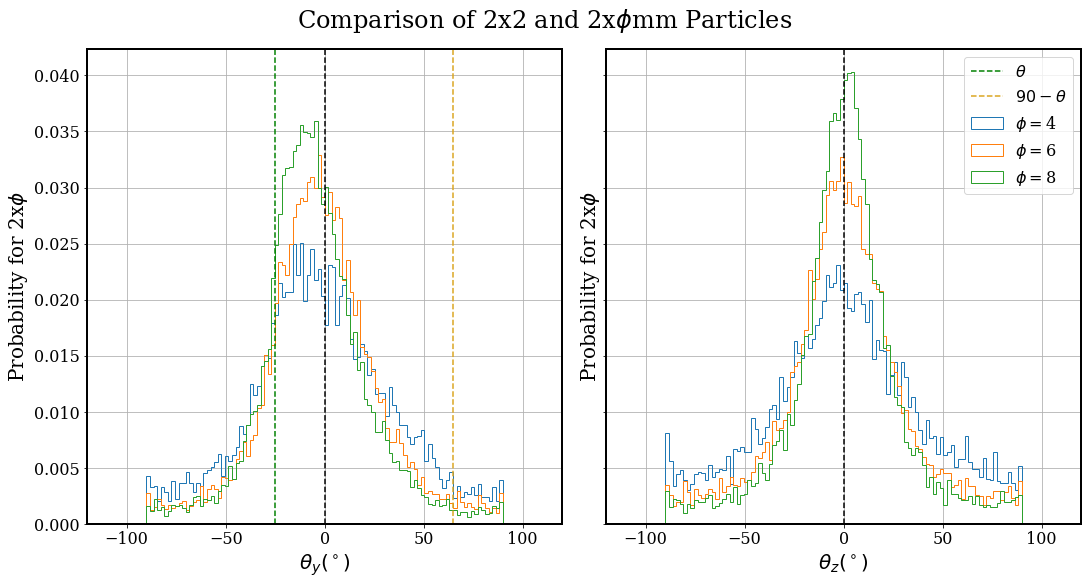

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

fig, (ax0, ax1) = plt.subplots(1,2,figsize=(15,8),sharey=True)
ax0.set_box_aspect(1), ax1.set_box_aspect(1)

with open('filenames.txt','r') as file:
    for name in file:
        name = name.rstrip('\n')
        if name.startswith('22'): # only names starting with '22'
            df = pd.read_pickle('DataFrames/'+name+'_CleanDF') # reads clean dataframe

            df1 = df[df.c.round(4) == (float(name[1])/2000) ] # divides into 2 particles
            df2 = df[df.c.round(4) == (float(name[3])/2000) ]
            
            n_bins = 100 # arbitrary

            weights_2=np.ones_like(df2.thetay)/len(df2.thetay) # to get probability instead of density
            ax0.hist(df2.thetay, n_bins, weights=weights_2, histtype='step', label='$\phi = $' + str(name[3]))
            weights_4=np.ones_like(df2.thetaz)/len(df2.thetaz)
            ax1.hist(df2.thetaz, n_bins, weights=weights_4, histtype='step')

ax0.axvline(x=0, color='black', linestyle='--')
ax1.axvline(x=0, color='black', linestyle='--')

ax0.axvline(x=-25, color='green', linestyle='--', label=r'$\theta$')
ax0.axvline(x=65, color='goldenrod', linestyle='--', label=r'$90-\theta$')

ax0.set(xlabel=r'$\theta_y (^\circ)$', ylabel='Probability for 2x'+'$\phi$', xlim=(-120,120))
ax1.set(xlabel=r'$\theta_z (^\circ)$', ylabel='Probability for 2x'+'$\phi$', xlim=(-120,120))
plt.suptitle('Comparison of 2x2 and 2x'+'$\phi$'+'mm Particles')

handles, labels = ax0.get_legend_handles_labels()
plt.legend(handles, labels, loc='best')

plt.savefig('Figures/Comparison_2x2_2xPHI.png', dpi=300)

## Angles Error Bars 
errorBars creates error bars of $\theta_y$ and $\theta_z$. On average, the shortest particle length is 0.002 m, therefore each bin is calculated to be 25x0.002 m long. 

In [7]:
def errorBars(name):
    '''Creates error bars of thetay and thetaz plotted against Xprime. '''
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    df = pd.read_pickle('DataFrames/'+name+'_CleanDF') # get clean dataframe
    
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(15,5)) # create figure
    ax0.set_box_aspect(1), ax1.set_box_aspect(1), ax2.set_box_aspect(1)

    ax1.axhline(y=-25, color='green', linestyle='--', label = r'$\theta$') # line at slope

    bin_num=int(df.xprime.max()/0.05) # calculated by taking 25*0.002mm. 

    df = df[df.a != 0]
    df1 = df[df.c.round(4) == (float(name[1])/2000) ]
    df2 = df[df.c.round(4) == (float(name[3])/2000) ]

    df1 = df1.sort_values(by=['xprime']) # stort dataframe values by xprime
    df1['bin'] = pd.cut(df1.xprime,bin_num, include_lowest = True) # cut dataframe into bin_num
    group = df1.groupby('bin') 
    dfs1 = [group.get_group(x) for x in group.groups] # stores all cut up dataframes into one dataframe called dfs1

    df2 = df2.sort_values(by=['xprime'])
    df2['bin'] = pd.cut(df2.xprime,bin_num, include_lowest = True)
    group = df2.groupby('bin')
    dfs2 = [group.get_group(x) for x in group.groups]

    df_all = df.sort_values(by=['xprime'])
    df_all['bin'] = pd.cut(df_all.xprime, bin_num, include_lowest = True)
    group = df_all.groupby('bin')
    dfs_all = [group.get_group(x) for x in group.groups]
    
    mean_y1, mean_z1, std_y1, std_z1, loc1 = [],[],[],[],[]
    for i in range(bin_num):
        sns.scatterplot(data=dfs_all[i], x='x', y='z',ax=ax0, s=2) # plot scatterplot  
        mean_y1.append(dfs1[i].thetay.mean()) # thetay mean
        std_y1.append(dfs1[i].thetay.std()/np.sqrt(len(dfs1[i].index))) # thetay std divided by sqrt(number in bin)
        mean_z1.append(dfs1[i].thetaz.mean()) # thetaz mean
        std_z1.append(dfs1[i].thetaz.std()/np.sqrt(len(dfs1[i].index)))
        loc1.append(dfs1[i].xprime.mean()) # location of bins along xprime

    mean_y2, mean_z2, std_y2, std_z2, loc2 = [],[],[],[],[]
    for i in range(bin_num):
        mean_y2.append(dfs2[i].thetay.mean())
        std_y2.append(dfs2[i].thetay.std()/np.sqrt(len(dfs2[i].index)))
        mean_z2.append(dfs2[i].thetaz.mean())
        std_z2.append(dfs2[i].thetaz.std()/np.sqrt(len(dfs2[i].index)))
        loc2.append(dfs2[i].xprime.mean())

    ax1.errorbar(loc1, mean_y1, yerr=std_y1, fmt='-o', label=str(name[0]) + 'x' + str(name[1])) # plot
    ax2.errorbar(loc1, mean_z1, yerr=std_z1, fmt='-o', label=str(name[0]) + 'x' + str(name[1]))
    ax1.errorbar(loc2, mean_y2, yerr=std_y2, fmt='-o', label=str(name[2]) + 'x' + str(name[3]))   
    ax2.errorbar(loc2, mean_z2, yerr=std_z2, fmt='-o', label=str(name[2]) + 'x' + str(name[3]))

    ax1.set(xlim=(df1.xprime.min(),df1.xprime.max()), ylim=(-90,90), xlabel='X\'', ylabel=r'$\theta_y$')
    ax2.set(xlim=(df1.xprime.min(),df1.xprime.max()), ylim=(-90,90), xlabel='X\'', ylabel=r'$\theta_z$')

    handles, labels = ax1.get_legend_handles_labels()
    plt.legend(handles, labels, loc='best')
    plt.suptitle(str(name[0]) + 'x' + str(name[1]) + ' and '+str(name[2]) + 'x' + str(name[3]) + 'mm Particles')
    ax0.margins(x=0, y=0)
    ax0.title.set_text('Binning of Data')
    ax1.title.set_text(r'$\theta_y$ vs. ' + 'X\'')
    ax2.title.set_text(r'$\theta_z$ vs. ' + 'X\'')
    
    plt.savefig('Figures/errorBars/'+str(name)+'.png', dpi=300)
    return plt.close()

In [ ]:
#run errorBars for all files in RawData#
with open('filenames.txt') as file:
    for name in file:
        errorBars(name.rstrip('\n'))

![](errorbars.png)

The error bar graphs correspond to the probability graphs above and show that there is not a strong correlation between the angles and X'. 

For a visual understanding of what these angles mean, we refer the reader to 3 Angles & Binning. 